# Dense Neural Networks

Hello there!

In this notebook we calculate the $Q^{2} Ext$. Finally, we used the Test Set.

## Mutual Information

### **Mutual Information (MI) for Feature Selection**  
**Mutual Information** measures the **statistical dependence** between two variables, capturing **both linear and nonlinear relationships**. Unlike Pearson correlation (which only detects linear trends), MI quantifies how much knowing one variable reduces uncertainty about the other.  

#### **Mathematical Definition**  
For two continuous variables \( X \) and \( Y \):  

$\text{MI}(X, Y) = \iint p(x, y) \log \left( \frac{p(x, y)}{p(x)p(y)} \right) dx \, dy$  
where:  
- $( p(x, y) )$ = joint probability density.  
- $( p(x), p(y) )$ = marginal densities.  

**Key Properties**:  
- $MI (\geq 0)$ (0 means independent).  
- Higher MI = stronger dependency.  


## Used libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
colab = False

In [3]:
if colab: 
    import sys
    sys.path.append('/content/drive/MyDrive/Colaboracion_Quimica/Main_Codes/AutoEncoders/AmaroX/AmaroX')
    ! pip install python-telegram-bot

    from ai_functions import *
    from ai_models import *
    from utilities import *
    from data_manipulation import *
    import pandas as pd
else: 
    from AmaroX.AmaroX.ai_functions import *
    from AmaroX.AmaroX.ai_models import *
    from AmaroX.AmaroX.utilities import *
    from AmaroX.AmaroX.data_manipulation import *
    import pandas as pd
    import sklearn

2025-08-19 20:32:48.648581: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-19 20:32:50.177156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/alan-amaro/miniconda3/envs/farma/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Data

The data presented here corresponds to molecules with their SMILE representation and descriptors, along with the biological activity. Let's first do a quick view of the data shape.

* All the data presented here was obtained by colaboration with Dr. Erick Padilla at Facultad de Estudios Superiores Zaragoza - UNAM.

### Downloading the data

In [4]:
if colab:
    ! gdown --id 1cHM9neEhTOZ82UU9HaZkdGdlwE1d4SJT
    ! gdown --id 1wZp9pou63ElEYyGGjBeC2pDtscgRgCpj

The _data.xlsx_ file contains all the molecular descriptors from the molecule, along with a SMILE representation.

In [5]:
compounds_md = pd.read_excel("/media/alan-amaro/XicoDisk/Data_Farma_FESZ/Antibiotics_71/Data/data.xlsx")
activity = pd.read_excel("/media/alan-amaro/XicoDisk/Data_Farma_FESZ/Antibiotics_71/Data/Actividad.xlsx")

In [6]:
compounds_md.head()

,Cmpd,SMILES,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,Compuesto original,O=C(N/1)/C(SC1=N/C2=NC3=CC=C(F)C=C3S2)=C/N4CCN...,module 'numpy' has no attribute 'float'.\n `np...,module 'numpy' has no attribute 'float'.\n `np...,0,3,34.64084,2.428932,4.709973,34.64084,...,10.158170,78.17227,405.1093,8.619347,2138,39,146,171,8.361111,5.750000
1,Compound 3,O=C1NC2=CC=C([H])C=C2/C1=N\C3=CC=CC(Br)=N3,module 'numpy' has no attribute 'float'.\n `np...,module 'numpy' has no attribute 'float'.\n `np...,0,0,23.43385,2.452376,4.754134,23.43385,...,9.792612,65.48686,300.9851,11.576350,599,26,96,113,5.166667,3.916667
2,Compound 4,O=C1NC2=CC=CC=C2/C1=N\C3=NC4=CC(OCC)=CC=C4S3,module 'numpy' has no attribute 'float'.\n `np...,module 'numpy' has no attribute 'float'.\n `np...,0,0,30.43085,2.474251,4.745881,30.43085,...,10.101640,73.78306,323.0728,8.974246,1245,35,126,151,6.138889,5.027778
3,Compound 8,O=C1NC2=CC=C(Br)C=C2/C1=N\C3=CC=CC(F)=N3,module 'numpy' has no attribute 'float'.\n `np...,module 'numpy' has no attribute 'float'.\n `np...,0,0,24.52891,2.46582,4.787297,24.52891,...,9.873183,66.82214,318.9757,12.268290,693,28,102,120,6.027778,4.083333
4,Compound 9,O=C1NC2=CC=C(Br)C=C2/C1=N/C3=CC([N+]([O-])=O)=...,module 'numpy' has no attribute 'float'.\n `np...,module 'numpy' has no attribute 'float'.\n `np...,0,0,27.00118,2.467278,4.80069,27.00118,...,9.972407,69.29945,345.9702,12.356080,929,32,112,132,7.138889,4.527778


In [7]:
compounds_md.shape

(71, 1828)

In [8]:
activity.head()

,Activity
0,5.005513
1,4.381642
2,4.114064
3,5.012402
4,5.047677


In [9]:
activity.shape

(71, 1)

* The variable _x_ are the molecular descriptors, we're only interested in numerical properties:

In [10]:
x = compounds_md.copy()
x = x.select_dtypes("number")

## Applying Mutual Information to Molecular Descriptors

In the previous notebook, we have selected 3 molecular descriptors that are independent among them and present a high MI with respect to the bio-activity.

In [11]:
x_array = np.array(x[ ['piPC4', 'GATS3i'] ])
x_array.shape

(71, 2)

In [12]:
y_array = np.array( activity )[:, 0]
y_array.shape

(71,)

## Standarize Features

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [14]:
x_std = scaler.fit_transform(x_array)
x_std.shape

(71, 2)

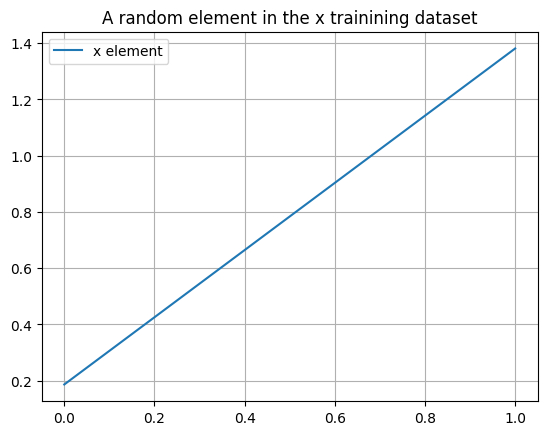

The corresponding y element -> 5.68915341


In [15]:
plot_xy([x_std, y_array])

## Splitting Train and Test

In [16]:
N_BINS=7 ##discretizer, this was 10 before
N_SPLITS=7 ##splitter
TEST_SIZE=21/70 ##splitter

In [17]:
# dividimos train test con stratified
discretizer = sklearn.preprocessing.KBinsDiscretizer(n_bins=N_BINS, encode="ordinal", strategy="uniform")
splitter = sklearn.model_selection.StratifiedShuffleSplit(n_splits=N_SPLITS,test_size=TEST_SIZE, random_state=13)
y_discrete = discretizer.fit_transform(np.expand_dims(y_array, axis = -1))
split, split_test = next(splitter.split(np.expand_dims(x_std, axis = -1), y_discrete ))

In [18]:
x_train = x_std[split]
x_test = x_std[split_test]
y_train = y_array[split]
y_test = y_array[split_test]

In [19]:
x_train.shape, x_test.shape

((49, 2), (22, 2))

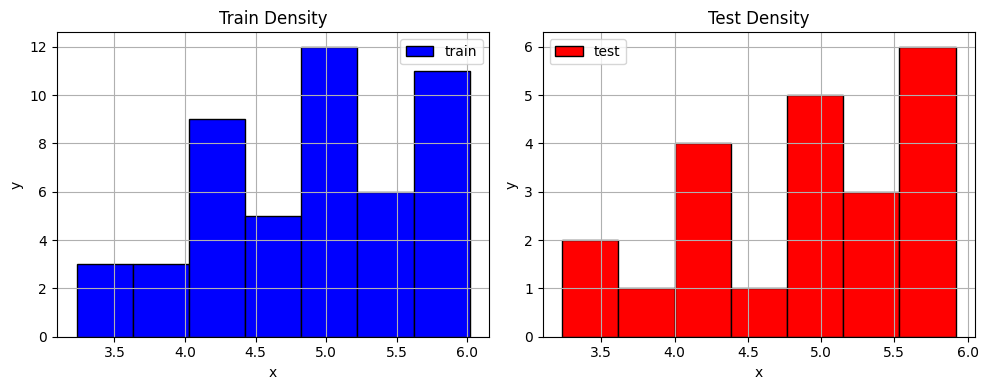

In [20]:
# Crear una figura con dos subplots en horizontal (1 fila, 2 columnas)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # figsize ajusta el tamaño

# Graficar la primera curva en el primer subplot
ax1.hist(y_train, color='blue', label='train', bins = 7, edgecolor = 'black')
ax1.set_title('Train Density')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid()
ax1.legend()

# Graficar la segunda curva en el segundo subplot
ax2.hist(y_test, color='red', label='test', bins = 7, edgecolor = 'black')
ax2.set_title('Test Density')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.grid()
ax2.legend()

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

## Paths

In [21]:
name = 'DNN_MI_2_FULL_Q2'
if colab:
    folder_path = '/content/drive/MyDrive/Colaboracion_Quimica/Main_Codes/AutoEncoders/models'
else: 
    folder_path = '../models'
    
final_path = os.path.join(folder_path, name)

## Callbacks

In [22]:
callbacks = standard_callbacks(folder_name= name,
                               folder_path= folder_path,
                               patiences= [120, 1000], # 50 epochs without progress, and 2 epochs to reduce LR
                               monitor = 'val_r2_score',
                               flow_direction = 'max')

## Seed

In [23]:
keras.utils.set_random_seed(1360)

## DNN Model

In [24]:
def _DNN():

  inputs = keras.layers.Input((2,))

  _DNN_ = G_Dense(
      inputs = inputs,
      nodes = [32, 161],
      DP = 5,
      n_final = 1,
      act_func = 'leaky_relu',
      final_act_func = 'relu',
      WI = 'he_normal',
      L1 = 0.0,
      L2 = 0.0,
      use_bias = True
  )

  return keras.models.Model(inputs = inputs, outputs = _DNN_)

In [25]:
model_DNN= _DNN()

2025-08-19 20:33:09.415726: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-08-19 20:33:09.415792: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: alan-amaro-Nvidia
2025-08-19 20:33:09.415814: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: alan-amaro-Nvidia
2025-08-19 20:33:09.416125: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 570.169.0
2025-08-19 20:33:09.416176: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 570.169.0
2025-08-19 20:33:09.416194: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 570.169.0


In [26]:
model_DNN.compile(optimizer = keras.optimizers.Adam(),
                    loss = 'mae',
                    metrics = ['mape', 'r2_score'])

In [27]:
get_plot_model(model_DNN, folder_path= final_path)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [28]:
model_DNN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 161)            │         5,313 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 161)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 161)            │           644 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           162 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,343 (24.78 KB)

 Trainable params: 5,957 (23.27 KB)

 Non-trainable params: 386 (1.51 KB)

## Training

In [29]:
model_trained = model_training(model_DNN,
                               folder_path = final_path,
                               batch_size = 12,
                               num_epochs = 1000,
                               x_train = x_train,
                               y_train = y_train,
                               x_val = x_test,
                               y_val = y_test,
                               callbacks = callbacks)

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - loss: 4.3441 - mape: 89.6110 - r2_score: -38.6016 - val_loss: 4.1061 - val_mape: 84.0413 - val_r2_score: -28.4432 - learning_rate: 0.0010
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 3.8132 - mape: 78.9836 - r2_score: -31.2873 - val_loss: 3.8702 - val_mape: 79.2699 - val_r2_score: -26.5287 - learning_rate: 0.0010
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 3.4568 - mape: 71.6736 - r2_score: -28.1851 - val_loss: 3.5778 - val_mape: 72.9195 - val_r2_score: -24.7492 - learning_rate: 0.0010
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 3.1494 - mape: 64.9454 - r2_score: -25.2004 - val_loss: 3.2980 - val_mape: 66.2911 - val_r2_score: -23.3687 - learning_rate: 0.0010
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 2.9149 - mape: 59.7002 - r2_score: -23.0885 - val_loss: 3.0813 - val_mape: 60.3355 - val_r2_score: -22.4059 - learning_rate: 0.0010
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81m

## Save Model

In [30]:
model_DNN.save( os.path.join(final_path, 'model.h5') )

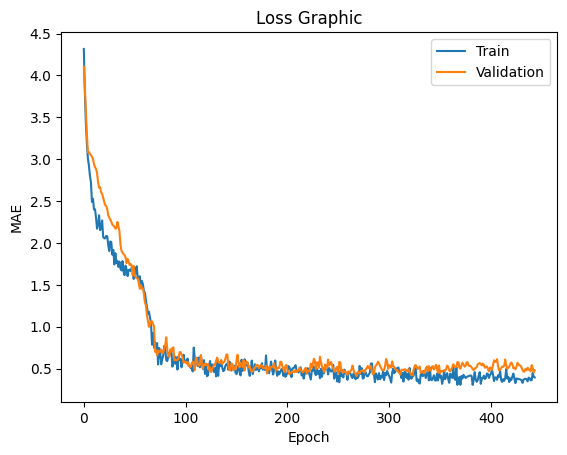

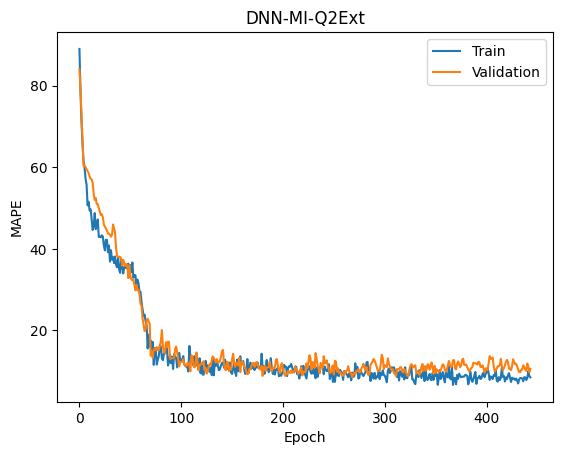

In [32]:
do_graphics(
    model_trained,
    'DNN-MI-Q2Ext',
    ('MAE', 'MAPE'),
    final_path,
    metric = 'mape'
)

## Evaluate

In [33]:
loss, accuracy, _ = evaluate_model_regression(model_DNN, x_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.4235 - mape: 8.7431 - r2_score: 0.5719
-> Loss = 0.42349520325660706
-> Test Accuracy = 8.743084907531738
-> R2 Accuracy = 0.5718732476234436


## KDE Comparison

In [34]:
import seaborn as sns

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


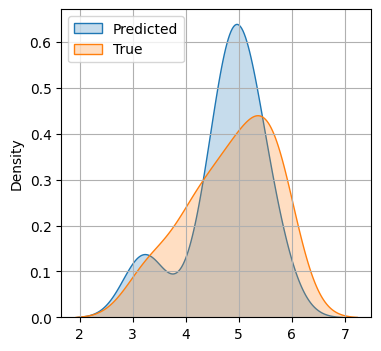

In [35]:
plt.figure(figsize = (4,4))
sns.kdeplot( model_DNN.predict(x_test), label = 'Predicted', fill= True)
sns.kdeplot(y_test, label = 'True', fill = True)
plt.grid()
plt.legend()
plt.show()

## Comparative Plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


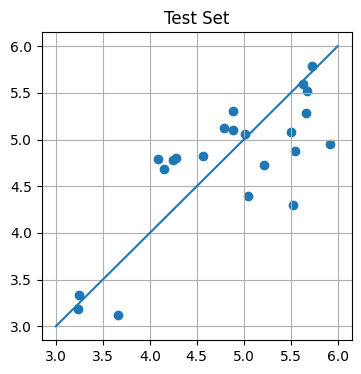

In [36]:
plt.figure(figsize = (4,4))
plt.plot([x for x in range(3, 7)], [x for x in range(3, 7)])
plt.scatter(y_test, model_DNN.predict(x_test))
#sns.kdeplot(y_test, label = 'True', fill = True)
plt.grid()
plt.title('Test Set')
plt.show()